<a href="https://colab.research.google.com/github/Sinchana731/Fake-news-detection-using-NLP/blob/main/nlp_proj2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout

import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [ ]:
import pandas as pd
real_data = pd.read_csv('True.csv')
fake_data = pd.read_csv('Fake.csv')

In [ ]:
real_data.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
fake_data.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
real_data['target'] = 1
fake_data['target'] = 0

In [ ]:
#Merging the 2 datasets
data = pd.concat([real_data, fake_data], ignore_index=True, sort=False)
data.head()

,title,text,subject,date,target
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [ ]:
data.isnull().sum()

,0
title,0
text,0
subject,0
date,0
target,0


subject
politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: count, dtype: int64


Text(0.5, 1.0, 'Distribution of The Subject According to Real and Fake Data')

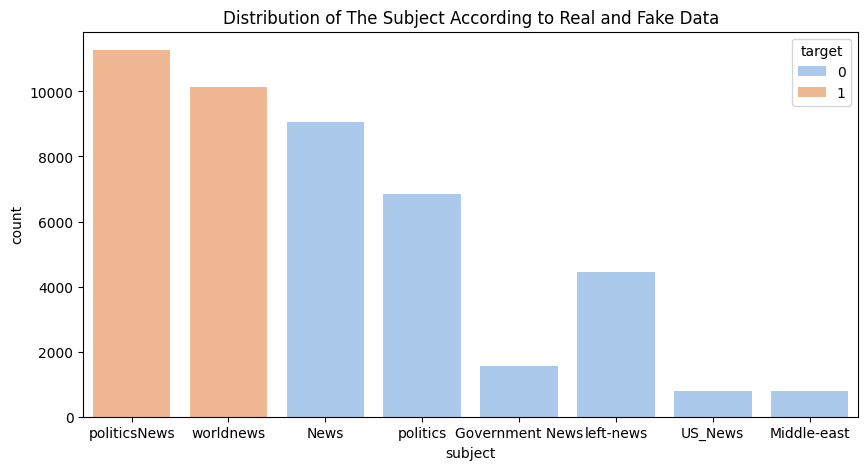

In [ ]:
print(data.subject.value_counts())
plt.figure(figsize=(10, 5))

ax = sns.countplot(x="subject",  hue='target', data=data, palette="pastel")
plt.title("Distribution of The Subject According to Real and Fake Data")

In [ ]:
data['text']= data['subject'] + " " + data['title'] + " " + data['text']
del data['title']
del data['subject']
del data['date']
data.head()

,text,target
0,"politicsNews As U.S. budget fight looms, Repub...",1
1,politicsNews U.S. military to accept transgend...,1
2,politicsNews Senior U.S. Republican senator: '...,1
3,politicsNews FBI Russia probe helped by Austra...,1
4,politicsNews Trump wants Postal Service to cha...,1


In [ ]:
first_text = data.text[10]
first_text

'politicsNews Jones certified U.S. Senate winner despite Moore challenge (Reuters) - Alabama officials on Thursday certified Democrat Doug Jones the winner of the state’s U.S. Senate race, after a state judge denied a challenge by Republican Roy Moore, whose campaign was derailed by accusations of sexual misconduct with teenage girls. Jones won the vacant seat by about 22,000 votes, or 1.6 percentage points, election officials said. That made him the first Democrat in a quarter of a century to win a Senate seat in Alabama.  The seat was previously held by Republican Jeff Sessions, who was tapped by U.S. President Donald Trump as attorney general. A state canvassing board composed of Alabama Secretary of State John Merrill, Governor Kay Ivey and Attorney General Steve Marshall certified the election results. Seating Jones will narrow the Republican majority in the Senate to 51 of 100 seats. In a statement, Jones called his victory “a new chapter” and pledged to work with both parties. M

Removal of HTML content

In [ ]:
pip install bs4

In [ ]:
from bs4 import BeautifulSoup

soup = BeautifulSoup(first_text, "html.parser")
first_text = soup.get_text()
first_text

'politicsNews Jones certified U.S. Senate winner despite Moore challenge (Reuters) - Alabama officials on Thursday certified Democrat Doug Jones the winner of the state’s U.S. Senate race, after a state judge denied a challenge by Republican Roy Moore, whose campaign was derailed by accusations of sexual misconduct with teenage girls. Jones won the vacant seat by about 22,000 votes, or 1.6 percentage points, election officials said. That made him the first Democrat in a quarter of a century to win a Senate seat in Alabama.  The seat was previously held by Republican Jeff Sessions, who was tapped by U.S. President Donald Trump as attorney general. A state canvassing board composed of Alabama Secretary of State John Merrill, Governor Kay Ivey and Attorney General Steve Marshall certified the election results. Seating Jones will narrow the Republican majority in the Senate to 51 of 100 seats. In a statement, Jones called his victory “a new chapter” and pledged to work with both parties. M

Removal of punctuation and special characters

In [ ]:
first_text = re.sub('\[[^]]*\]', ' ', first_text)
first_text = re.sub('[^a-zA-Z]',' ',first_text)  # replaces non-alphabets with spaces
first_text = first_text.lower() # Converting from uppercase to lowercase
first_text

'politicsnews jones certified u s  senate winner despite moore challenge  reuters    alabama officials on thursday certified democrat doug jones the winner of the state s u s  senate race  after a state judge denied a challenge by republican roy moore  whose campaign was derailed by accusations of sexual misconduct with teenage girls  jones won the vacant seat by about        votes  or     percentage points  election officials said  that made him the first democrat in a quarter of a century to win a senate seat in alabama   the seat was previously held by republican jeff sessions  who was tapped by u s  president donald trump as attorney general  a state canvassing board composed of alabama secretary of state john merrill  governor kay ivey and attorney general steve marshall certified the election results  seating jones will narrow the republican majority in the senate to    of     seats  in a statement  jones called his victory  a new chapter  and pledged to work with both parties  m

Removal of Stopwords

In [ ]:
import nltk

nltk.download("punkt_tab")
nltk.download("punkt")
nltk.download("stopwords")
from nltk.corpus import stopwords

# we can use tokenizer instead of split
first_text = nltk.word_tokenize(first_text)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
first_text

['politicsnews',
 'jones',
 'certified',
 'u',
 's',
 'senate',
 'winner',
 'despite',
 'moore',
 'challenge',
 'reuters',
 'alabama',
 'officials',
 'on',
 'thursday',
 'certified',
 'democrat',
 'doug',
 'jones',
 'the',
 'winner',
 'of',
 'the',
 'state',
 's',
 'u',
 's',
 'senate',
 'race',
 'after',
 'a',
 'state',
 'judge',
 'denied',
 'a',
 'challenge',
 'by',
 'republican',
 'roy',
 'moore',
 'whose',
 'campaign',
 'was',
 'derailed',
 'by',
 'accusations',
 'of',
 'sexual',
 'misconduct',
 'with',
 'teenage',
 'girls',
 'jones',
 'won',
 'the',
 'vacant',
 'seat',
 'by',
 'about',
 'votes',
 'or',
 'percentage',
 'points',
 'election',
 'officials',
 'said',
 'that',
 'made',
 'him',
 'the',
 'first',
 'democrat',
 'in',
 'a',
 'quarter',
 'of',
 'a',
 'century',
 'to',
 'win',
 'a',
 'senate',
 'seat',
 'in',
 'alabama',
 'the',
 'seat',
 'was',
 'previously',
 'held',
 'by',
 'republican',
 'jeff',
 'sessions',
 'who',
 'was',
 'tapped',
 'by',
 'u',
 's',
 'president',
 'd

In [ ]:
first_text = [ word for word in first_text if not word in set(stopwords.words("english"))]

Lemmatization

In [ ]:
nltk.download("wordnet")
lemma = nltk.WordNetLemmatizer()
first_text = [ lemma.lemmatize(word) for word in first_text]

first_text = " ".join(first_text)
first_text

[nltk_data] Downloading package wordnet to /root/nltk_data...


'politicsnews jones certified u senate winner despite moore challenge reuters alabama official thursday certified democrat doug jones winner state u senate race state judge denied challenge republican roy moore whose campaign derailed accusation sexual misconduct teenage girl jones vacant seat vote percentage point election official said made first democrat quarter century win senate seat alabama seat previously held republican jeff session tapped u president donald trump attorney general state canvassing board composed alabama secretary state john merrill governor kay ivey attorney general steve marshall certified election result seating jones narrow republican majority senate seat statement jones called victory new chapter pledged work party moore declined concede defeat even trump urged stood claim fraudulent election statement released certification said regret medium outlet reported alabama judge denied moore request block certification result dec election decision shortly canvass

In [ ]:
#Removal of HTML Contents
def remove_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removal of Punctuation Marks
def remove_punctuations(text):
    return re.sub('\[[^]]*\]', '', text)

# Removal of Special Characters
def remove_characters(text):
    return re.sub("[^a-zA-Z]"," ",text)

#Removal of stopwords
def remove_stopwords_and_lemmatization(text):
    final_text = []
    text = text.lower()
    text = nltk.word_tokenize(text)

    for word in text:
        if word not in set(stopwords.words('english')):
            lemma = nltk.WordNetLemmatizer()
            word = lemma.lemmatize(word)
            final_text.append(word)
    return " ".join(final_text)

#Total function
def cleaning(text):
    text = remove_html(text)
    text = remove_punctuations(text)
    text = remove_characters(text)
    text = remove_stopwords_and_lemmatization(text)
    return text

#Apply function on text column
data['text']=data['text'].apply(cleaning)

In [ ]:
data.head()

,text,target
0,politicsnews u budget fight loom republican fl...,1
1,politicsnews u military accept transgender rec...,1
2,politicsnews senior u republican senator let m...,1
3,politicsnews fbi russia probe helped australia...,1
4,politicsnews trump want postal service charge ...,1


Number of words in each text

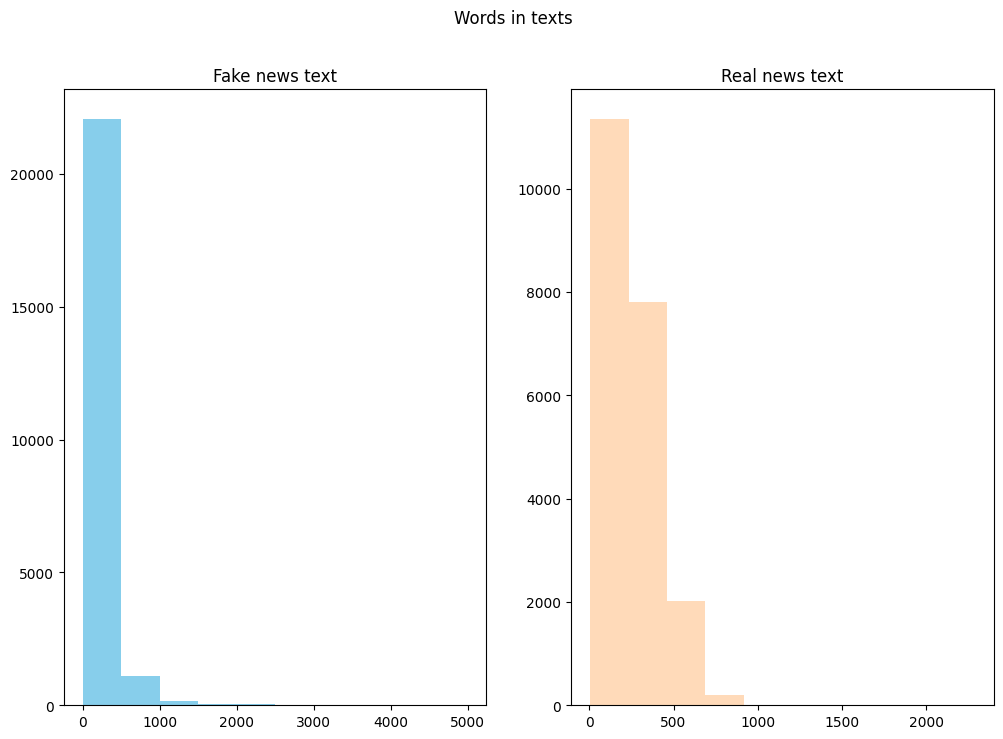

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=data[data['target']==0]['text'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='SkyBlue')
ax1.set_title('Fake news text')
text_len=data[data['target']==1]['text'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='PeachPuff')
ax2.set_title('Real news text')
fig.suptitle('Words in texts')
plt.show()


The number of words seems to be a bit different. 500 words are most common in real news category while around 250 words are most common in fake news category.

N gram analysis

In [ ]:
texts = ' '.join(data['text'])

In [ ]:
string = texts.split(" ")

In [ ]:
def draw_n_gram(string,i):
    n_gram = (pd.Series(nltk.ngrams(string, i)).value_counts())[:15]
    n_gram_df=pd.DataFrame(n_gram)
    n_gram_df = n_gram_df.reset_index()
    n_gram_df = n_gram_df.rename(columns={"index": "word", 0: "count"})
    print(n_gram_df.head())
    plt.figure(figsize = (16,9))
    return sns.barplot(x='count',y='word', data=n_gram_df)

Trigram analysis

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<Figure size 1000x600 with 0 Axes>

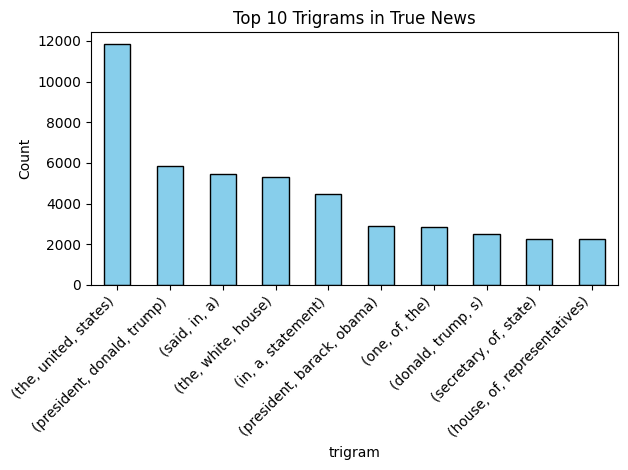

<Figure size 1000x600 with 0 Axes>

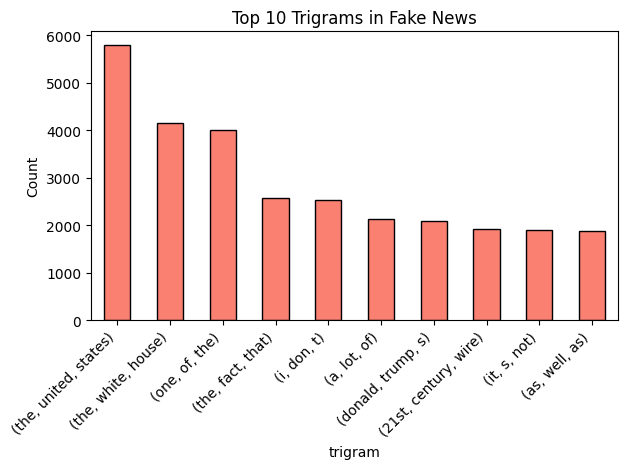

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from collections import Counter
import nltk

nltk.download('punkt')

def process_trigram_from_file(csv_path, label, text_column='text', top_k=10):
    # Read the CSV
    df = pd.read_csv(csv_path)

    if text_column not in df.columns:
        raise ValueError(f"Column '{text_column}' not found in {csv_path}")

    # Combine all text entries
    all_text = ' '.join(df[text_column].dropna().astype(str)).lower()

    # Tokenize and remove punctuation
    tokens = word_tokenize(all_text)
    tokens = [t for t in tokens if t.isalnum()]  # Remove punctuation

    # Generate trigrams
    trigram_list = list(ngrams(tokens, 3))
    trigram_counts = Counter(trigram_list)

    if not trigram_counts:
        print(f"No trigrams found in {label} dataset.")
        return

    # Create DataFrame
    trigram_df = pd.DataFrame(trigram_counts.items(), columns=['trigram', 'count'])
    trigram_df = trigram_df.sort_values(by='count', ascending=False).head(top_k)
    trigram_df.set_index('trigram', inplace=True)

    # Plot
    plt.figure(figsize=(10, 6))
    trigram_df.plot(kind='bar', legend=False, color='skyblue' if label == 'True' else 'salmon', edgecolor='black')
    plt.title(f'Top {top_k} Trigrams in {label} News')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Example usage:
process_trigram_from_file('True.csv', label='True')
process_trigram_from_file('Fake.csv', label='Fake')


Modeling

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['target'], random_state=0)

In [ ]:
max_features = 10000
maxlen = 300

In [ ]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)
tokenized_train = tokenizer.texts_to_sequences(X_train)
X_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

In [ ]:
tokenized_test = tokenizer.texts_to_sequences(X_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

Training LSTM model

In [ ]:
batch_size = 256
epochs = 10
embed_size = 100

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Define the necessary parameters
max_features = 10000  # Vocabulary size
embed_size = 100      # Embedding dimensions
maxlen = 100          # Maximum length of input sequences

# Build the model
model = Sequential()

# Non-trainable embedding layer
model.add(Embedding(input_dim=max_features, output_dim=embed_size, input_length=maxlen, trainable=False))

# LSTM layers with input shape explicitly defined in the first one
model.add(LSTM(units=128, return_sequences=True, recurrent_dropout=0.25, dropout=0.25, input_shape=(maxlen, embed_size)))
model.add(LSTM(units=64, recurrent_dropout=0.1, dropout=0.1))

# Dense layers
model.add(Dense(units=32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Binary classification output

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

# Build the model explicitly before printing summary
model.build(input_shape=(None, maxlen))

# Print the model summary
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 100, 128)       │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,168,769 (4.46 MB)

 Trainable params: 168,769 (659.25 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

In [ ]:
history = model.fit(X_train, y_train, validation_split=0.3, epochs=5, batch_size=batch_size, shuffle=True, verbose = 1)

Epoch 1/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 445s 5s/step - accuracy: 0.8588 - loss: 0.3172 - val_accuracy: 0.8845 - val_loss: 0.2711
Epoch 2/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 531s 5s/step - accuracy: 0.8747 - loss: 0.2996 - val_accuracy: 0.9112 - val_loss: 0.2569
Epoch 3/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 500s 5s/step - accuracy: 0.8580 - loss: 0.3324 - val_accuracy: 0.8544 - val_loss: 0.3691
Epoch 4/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 503s 5s/step - accuracy: 0.8969 - loss: 0.2568 - val_accuracy: 0.9326 - val_loss: 0.1823
Epoch 5/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 501s 5s/step - accuracy: 0.9256 - loss: 0.1941 - val_accuracy: 0.9478 - val_loss: 0.1494


In [ ]:
print("Accuracy of the model on Training Data is - " , model.evaluate(X_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

1053/1053 ━━━━━━━━━━━━━━━━━━━━ 216s 205ms/step - accuracy: 0.9503 - loss: 0.1416
Accuracy of the model on Training Data is -  94.97520327568054 %
351/351 ━━━━━━━━━━━━━━━━━━━━ 70s 200ms/step - accuracy: 0.9507 - loss: 0.1415
Accuracy of the model on Testing Data is -  95.0022280216217 %


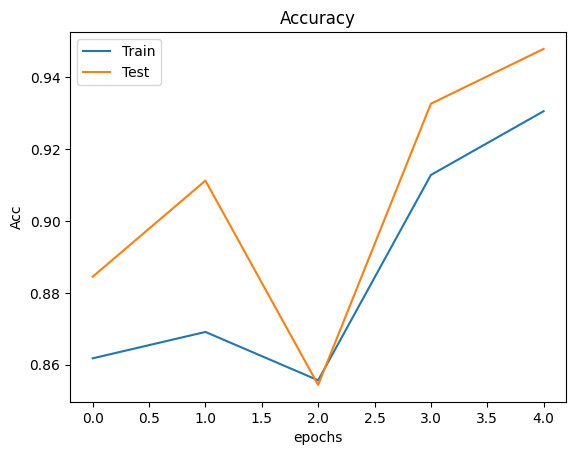

In [ ]:
plt.figure()
plt.plot(history.history["accuracy"], label = "Train")
plt.plot(history.history["val_accuracy"], label = "Test")
plt.title("Accuracy")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()


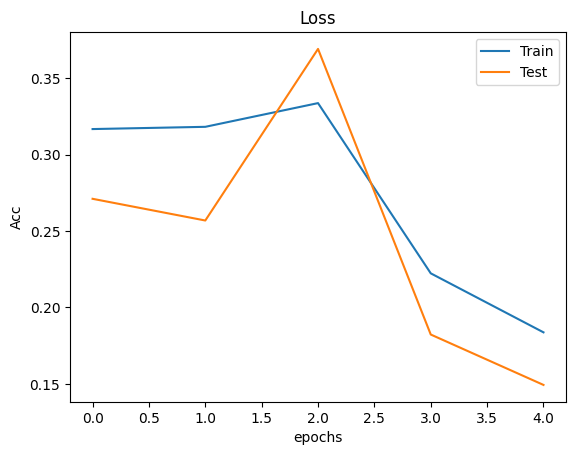

In [ ]:
plt.figure()
plt.plot(history.history["loss"], label = "Train")
plt.plot(history.history["val_loss"], label = "Test")
plt.title("Loss")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()
